<a href="https://colab.research.google.com/github/SEUNGJUNHH/2024-Machine-learning/blob/main/%ED%91%9C%EC%A0%95%EB%B6%84%EC%84%9D%20%EA%B8%B0%EB%B0%98%20%EC%9D%8C%EC%95%85%EC%B6%94%EC%B2%9C%20%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

모델 시작 전 api 이용하기

In [ ]:
pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 13.0 MB/s eta 0:00:00


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import pprint
cid = 'bcb8f54e1e2241d58d29a93980ca1213'
secret = '07329b5282294688b7c3762124d6d2f8'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
artist_name =[]
track_name = []
track_popularity =[]
artist_id =[]
track_id =[]
for i in range(0,1000,50):
    track_results = sp.search(q='year:2023', type='track', limit=50, offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        artist_id.append(t['artists'][0]['id'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        track_popularity.append(t['popularity'])

In [ ]:
import pandas as pd
track_df = pd.DataFrame({'artist_name' : artist_name, 'track_name' : track_name, 'track_id' : track_id, 'track_popularity' : track_popularity, 'artist_id' : artist_id})
print(track_df.shape)
track_df.head()

(1000, 5)


,artist_name,track_name,track_id,track_popularity,artist_id
0,EDM NATIVES,En Las Calles De Madrid,6FAQYF6s9cLAgjqWMepY2K,0,7MXzWeLsIPnP0k94VeHEpk
1,NEO JAPONISM,BLACK JAM,5AtSbXXDk4qhAGB49EsJpC,10,5HumUo2OdKgqtpk2vz1A10
2,Antonio Vivaldi,"Violin Concerto in D Major, RV 229: III. Allegro",5Ol12tmOy15avTj1lHJlb4,8,2QOIawHpSlOwXDvSqQ9YJR
3,Friox,Bludsteroo,0TFS3BcXVH0XiBFfOrOHXr,0,2qhzqC25sc5DlK6yWRy49j
4,Susmirata Dawalkar,Durga Sapta Shloki,5pdKWoIBErYq5Jv173HC9y,0,4Z30T0Qe2cZI9K6AwJEzGg


In [ ]:
track_features = []
for t_id in track_df['track_id']:
    af = sp.audio_features(t_id)
    track_features.append(af)
tf_df = pd.DataFrame(columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'])


In [ ]:
for item in track_features:
    for feat in item:
        if isinstance(feat, dict):
            feat_df = pd.DataFrame([feat])  # feat을 데이터프레임으로 변환
            tf_df = pd.concat([tf_df, feat_df], ignore_index=True)




In [ ]:
cols_to_drop2 = ['key','mode','type', 'uri','track_href','analysis_url']
tf_df = tf_df.drop(columns=cols_to_drop2)
tf_df.head()
print(track_df.info())
print(tf_df.info())

In [ ]:
track_df['artist_name'] = track_df['artist_name'].astype("string")
track_df['track_name'] = track_df['track_name'].astype("string")
track_df['track_id'] = track_df['track_id'].astype("string")
track_df['artist_id'] = track_df['artist_id'].astype("string")
tf_df['duration_ms'] = pd.to_numeric(tf_df['duration_ms'])
tf_df['instrumentalness'] = pd.to_numeric(tf_df['instrumentalness'])
tf_df['time_signature'] = tf_df['time_signature'].astype("category")
print(track_df.info())
print(tf_df.info())

In [ ]:
# tf_df와 track_df를 'id'와 'track_id'를 기준으로 병합
merged_df = pd.merge(tf_df, track_df[['track_id', 'artist_name', 'track_name']], left_on='id', right_on='track_id', how='left')

# 'track_id' 열은 이제 필요 없으므로 삭제
merged_df.drop(columns=['track_id'], inplace=True)

# 병합된 데이터프레임 출력


In [ ]:
emotion_criteria = {
    'happy': {
        'danceability': (0.7, 1.0),
        'energy': (0.7, 1.0),
        'valence': (0.7, 1.0),
        'tempo': (100, 140),
        'loudness': (-10, 0)
    },
    'panic': {
        'danceability': (0.5, 0.7),
        'energy': (0.3, 0.6),
        'valence': (0.5, 0.7),
        'tempo': (90, 120),
        'loudness': (-30, -15)
    },
    'angry': {
        'danceability': (0.4, 0.6),
        'energy': (0.7, 1.0),
        'valence': (0.2, 0.4),
        'tempo': (100, 140),
        'loudness': (-10, 0)
    },
    'hurt': {
        'danceability': (0.1, 0.3),
        'energy': (0.1, 0.4),
        'valence': (0.0, 0.4),
        'tempo': (60, 80),
        'loudness': (-20, -10)
    }
}

In [ ]:
# Function to filter songs based on emotion
def recommend_songs(emotion, df, criteria):
    filters = criteria[emotion]
    filtered_df = df[
        (df['danceability'] >= filters['danceability'][0]) & (df['danceability'] <= filters['danceability'][1]) &
        (df['energy'] >= filters['energy'][0]) & (df['energy'] <= filters['energy'][1]) &
        (df['valence'] >= filters['valence'][0]) & (df['valence'] <= filters['valence'][1]) &
        (df['tempo'] >= filters['tempo'][0]) & (df['tempo'] <= filters['tempo'][1]) &
        (df['loudness'] >= filters['loudness'][0]) & (df['loudness'] <= filters['loudness'][1])
    ]
    return filtered_df[['artist_name', 'track_name']].head(3)

모델 시작


In [ ]:
from PIL import Image
from glob import glob
import re
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from unicodedata import normalize
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/기계학습 팀 프로젝트/equalized_image"

label_list = ['happy', 'panic', 'angry', 'hurt']

def create_dataframe(data_path, label_list):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))
    print(f"Found {len(img_list)} images in {data_path}")

    for img in img_list:
        file_name = os.path.splitext(os.path.basename(img))[0]
        for idx, label in enumerate(label_list):
            if label in file_name:
                new_data = pd.DataFrame({"path": [img], "label": [label], "class_id": [idx]})
                df = pd.concat([df, new_data], ignore_index=True)
                break

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

# Create DataFrame and split into train, validation, and test sets
df = create_dataframe(data_path, label_list)
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['class_id'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class_id'], random_state=42)

print(f"train_data: {len(train_df)}")
print(f"val_data: {len(val_df)}")
print(f"test_data: {len(test_df)}")


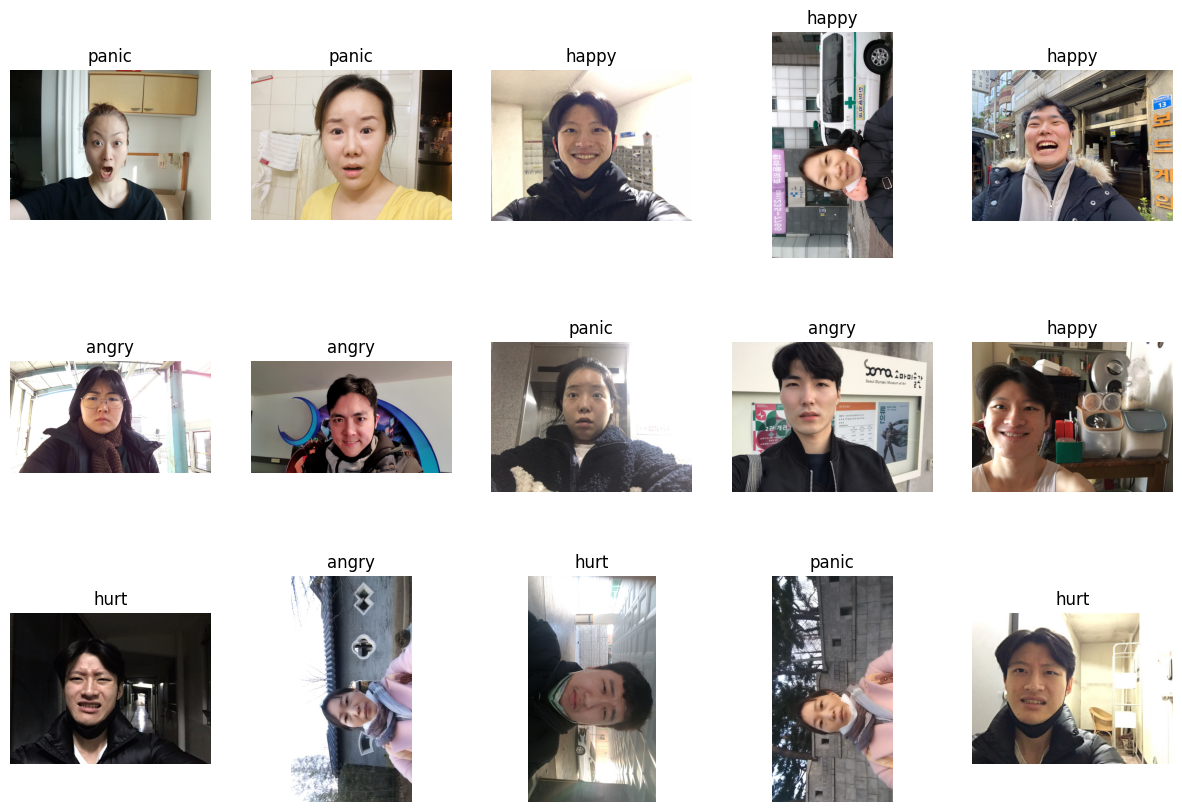

In [ ]:


show_imgs = 15
idx = np.random.randint(0, len(val_df), size=show_imgs)
fig, axes = plt.subplots(show_imgs // 5, 5, figsize=(15, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = val_df.iloc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.iloc[idx[i]]['label'])
    ax.set_axis_off()

In [ ]:
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2

class BaseDataset(Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

SimpleTransforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_dataset = BaseDataset(train_df, SimpleTransforms)
val_dataset = BaseDataset(val_df, SimpleTransforms)
test_dataset = BaseDataset(test_df, SimpleTransforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)



In [ ]:
import torch
import torchvision.transforms as v2
from torchvision import models

In [ ]:
class MyVGG16(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(MyVGG16, self).__init__()
        self.features = pretrained_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
myvgg16 = MyVGG16(vgg16, num_classes=len(label_list)).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 224MB/s]


In [ ]:
EPOCHS = 50
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myvgg16.parameters(), lr=0.0001)

patience = 10
counter = 0
best_loss = np.inf

In [ ]:
scaler = torch.cuda.amp.GradScaler()

def train(dataloader, model, loss_fn, optimizer, scaler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    epoch_loss, epoch_correct = 0, 0

    for data_, target_ in dataloader:
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(data_)
            loss = loss_fn(output, target_)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        epoch_correct += (output.argmax(1) == target_).type(torch.float).sum().item()

    train_acc = epoch_correct / size


    return train_acc, epoch_loss / num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss, epoch_correct = 0, 0
    model.eval()
    with torch.no_grad():
        for data_, target_ in dataloader:
            data_, target_ = data_.to(device), target_.to(device)
            output = model(data_)
            loss = loss_fn(output, target_)
            epoch_loss += loss.item()
            epoch_correct += (output.argmax(1) == target_).type(torch.float).sum().item()

    test_acc = epoch_correct / size

    return test_acc, epoch_loss / num_batches

In [ ]:
myvgg16.cuda()

MyVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader, myvgg16, criterion, optimizer,scaler)
    val_acc, val_loss = test(val_loader, myvgg16, criterion)
    print(f'epoch: {epoch} \
    train_loss = {train_loss:.4f}, train_acc: {train_acc:.4f} \
    val_loss = {val_loss:.4f}, val_acc: {val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myvgg16.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1

    if counter >= patience:
        test_acc, test_loss = test(test_loader, myvgg16, criterion)
        print("Early stop!")
        print(f'Test accuracy: {test_acc}')
        break
print(f'Test accuracy: {test_acc}')

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0     train_loss = 1.3793, train_acc: 0.2704     val_loss = 1.5095, val_acc: 0.2582     learning rate: 0.0001


  2%|▏         | 1/50 [05:20<4:21:26, 320.14s/it]

epoch: 1     train_loss = 1.2304, train_acc: 0.3746     val_loss = 1.2376, val_acc: 0.3961     learning rate: 0.0001


  4%|▍         | 2/50 [05:39<1:54:40, 143.33s/it]

epoch: 2     train_loss = 1.0637, train_acc: 0.4942     val_loss = 1.0655, val_acc: 0.4858     learning rate: 0.0001


  6%|▌         | 3/50 [05:58<1:07:53, 86.66s/it] 

epoch: 3     train_loss = 0.8709, train_acc: 0.5911     val_loss = 1.0308, val_acc: 0.5120     learning rate: 0.0001


 10%|█         | 5/50 [06:36<33:39, 44.88s/it]

epoch: 4     train_loss = 0.7359, train_acc: 0.6786     val_loss = 1.1067, val_acc: 0.5711     learning rate: 0.0001
epoch: 5     train_loss = 0.5878, train_acc: 0.7536     val_loss = 0.9853, val_acc: 0.6411     learning rate: 0.0001


 14%|█▍        | 7/50 [07:12<21:33, 30.08s/it]

epoch: 6     train_loss = 0.4342, train_acc: 0.8178     val_loss = 1.0023, val_acc: 0.6258     learning rate: 0.0001


 16%|█▌        | 8/50 [07:29<18:03, 25.80s/it]

epoch: 7     train_loss = 0.3327, train_acc: 0.8695     val_loss = 1.5237, val_acc: 0.6499     learning rate: 0.0001


 18%|█▊        | 9/50 [07:45<15:41, 22.97s/it]

epoch: 8     train_loss = 0.2302, train_acc: 0.9074     val_loss = 1.8059, val_acc: 0.6389     learning rate: 0.0001


 20%|██        | 10/50 [08:02<13:59, 20.98s/it]

epoch: 9     train_loss = 0.2166, train_acc: 0.9213     val_loss = 1.2859, val_acc: 0.6849     learning rate: 0.0001


 22%|██▏       | 11/50 [08:19<12:48, 19.71s/it]

epoch: 10     train_loss = 0.1772, train_acc: 0.9351     val_loss = 1.5144, val_acc: 0.6543     learning rate: 0.0001


 24%|██▍       | 12/50 [08:36<11:56, 18.87s/it]

epoch: 11     train_loss = 0.1181, train_acc: 0.9548     val_loss = 1.5678, val_acc: 0.6740     learning rate: 0.0001


 26%|██▌       | 13/50 [08:53<11:16, 18.27s/it]

epoch: 12     train_loss = 0.1492, train_acc: 0.9570     val_loss = 1.5223, val_acc: 0.6543     learning rate: 0.0001


 28%|██▊       | 14/50 [09:09<10:38, 17.75s/it]

epoch: 13     train_loss = 0.1018, train_acc: 0.9606     val_loss = 1.2673, val_acc: 0.6543     learning rate: 0.0001


 30%|███       | 15/50 [09:26<10:08, 17.38s/it]

epoch: 14     train_loss = 0.0370, train_acc: 0.9869     val_loss = 1.7343, val_acc: 0.6783     learning rate: 0.0001
epoch: 15     train_loss = 0.0827, train_acc: 0.9738     val_loss = 2.3613, val_acc: 0.6193     learning rate: 0.0001


 30%|███       | 15/50 [11:08<26:00, 44.60s/it]

Early stop!
Test accuracy: 0.7030567685589519
Test accuracy: 0.7030567685589519


In [ ]:
import itertools


lr_values = [0.0001, 0.001, 0.01]

best_accuracy = 0
best_lr = None

for lr in lr_values:

    vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    myvgg16 = MyVGG16(vgg16, num_classes=len(label_list)).to(device)


    optimizer = optim.Adam(myvgg16.parameters(), lr=lr)



    for epoch in range(EPOCHS):
        train_acc, train_loss = train(train_loader, myvgg16, criterion, optimizer, scaler)
        val_acc, val_loss = test(val_loader, myvgg16, criterion)


        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_lr = lr


print(f"Optimal learning rate: {best_lr}")



Optimal learning rate: 0.0001


In [ ]:
best_model = MyVGG16(vgg16, num_classes=len(label_list)).to(device)

#Initialize variables to track best accuracy and corresponding model state_dict
best_accuracy = 0
best_model_state_dict = None

#Set optimizer with best_lr
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)

#Train the model
for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_loader, best_model, criterion, optimizer, scaler)
    val_acc, val_loss = test(val_loader, best_model, criterion)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model_state_dict = best_model.state_dict()

#Load the best model state dict if available
if best_model_state_dict is not None:
    best_model.load_state_dict(best_model_state_dict)

#Evaluate the best model on the test set
test_acc, test_loss = test(test_loader, best_model, criterion)
print(f"Best model Test accuracy: {test_acc}")

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Best model로 예측
best_model.eval()
y_test_pred = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = best_model(data)
        pred = output.argmax(1)
        y_test_pred.extend(pred.cpu().numpy())

#Confusion matrix 계산
conf_matrix = confusion_matrix(test_df['class_id'], y_test_pred)

#F1, Precision, Recall 계산
f1 = f1_score(test_df['class_id'], y_test_pred, average='weighted')
precision = precision_score(test_df['class_id'], y_test_pred, average='weighted')
recall = recall_score(test_df['class_id'], y_test_pred, average='weighted')

#Classification report
class_report = classification_report(test_df['class_id'], y_test_pred, target_names=label_list)

#Confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix\nF1 Score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Classification report 시각화
plt.figure(figsize=(10, 8))
plt.text(0.01, 1.25, str('Classification Report'), {'fontsize': 12}, fontproperties='monospace')
plt.text(0.01, 0.05, str(class_report), {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')
plt.show()

In [ ]:
#Best model에 대한 ROC Curve와 AUROC 계산
y_test_prob = []
best_model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = best_model(data)
        probs = torch.softmax(output, dim=1)
        y_test_prob.extend(probs.cpu().numpy())

#클래스 수에 따라 label binarize
n_classes = len(label_list)
y_test_binarized = label_binarize(test_df['class_id'], classes=range(n_classes))

#ROC Curve와 AUROC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#평균 ROC Curve 계산
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#전체 ROC Curve 시각화
plt.figure(figsize=(10, 8))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {label_list[i]} (area = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

최종 결과물 확인(best.pth)

In [ ]:
model_state_dict = torch.load("checkpoints/best.pth")

myvgg16 = MyVGG16(vgg16, num_classes=len(label_list))
myvgg16.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:


myvgg16.eval()
myvgg16.to(device)

final_image_path = '/content/drive/MyDrive/기계학습 팀 프로젝트/new_imgs/fe5faafa4983ec70a2a46c3d86f725a131f59fb7e9f89863fbb0060521e2aebb_여_20_panic_공공시설&종교&의료시설_20210120121002-001-010.jpg'
final_image = Image.open(final_image_path).convert('RGB')  # Convert to RGB

test_image = final_image.resize((224, 224))

plt.imshow(test_image)
plt.axis('off')
plt.show()

SimpleTransforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_img = SimpleTransforms(test_image)
test_img = test_img.unsqueeze(0)
test_img = test_img.to('cuda')

# Perform prediction
final_output = myvgg16(test_img)
final_output = final_output.argmax(1)


if final_output.item() == 0:
    emotion = 'happy'
elif final_output.item() == 1:
    emotion = 'panic'
elif final_output.item() == 2:
    emotion = 'angry'
elif final_output.item() == 3:
    emotion = 'hurt'


print('The Answer is', emotion)

recommended_songs = recommend_songs(emotion, merged_df, emotion_criteria)
print(recommended_songs)




